In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-7kn544r2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-7kn544r2
  Resolved https://github.com/facebookresearch/detectron2.git to commit 70f454304e1a38378200459dd2dbca0f0f4a5ab4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6174357 sha256=8fbd4645012652a349f6456e2fc83

In [3]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
torch.cuda.is_available()

# Configure model
def configure_model():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    return cfg

# Initialize model and predictor
cfg = configure_model()
predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:01, 108MB/s]                           


In [5]:
def create_mask(image_path):
    # Load image
    img = cv2.imread(image_path)

    # Use Mask R-CNN to predict instances
    outputs = predictor(img)

    # Extract masks
    masks = outputs["instances"].pred_masks.cpu().numpy()

    # Create a combined mask (summing up all instance masks)
    combined_mask = np.zeros_like(img[:, :, 0])
    for mask in masks:
        combined_mask += mask.astype(np.uint8) * 255

    # Apply smoothing (optional)
    combined_mask = cv2.GaussianBlur(combined_mask, (5, 5), 0)

    # Display original image and mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img[:, :, ::-1])  # Convert BGR to RGB for display
    plt.subplot(1, 2, 2)
    plt.title('Mask R-CNN Mask')
    plt.imshow(combined_mask, cmap='gray')
    plt.show()

    return combined_mask

In [6]:
# Function to extract numbers from filename
def extract_numbers_from_filename(filename):
    # Use regular expression to find numbers in the filename
    match = re.search(r'\d+', filename)

    # If numbers are found, convert them to an integer
    if match:
        return int(match.group())
    else:
        return None

In [7]:
# Function to remove small blobs from mask
def remove_small_blobs(mask, min_blob_size):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours (blobs)
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= min_blob_size]

    # Create an empty mask to draw the filtered contours
    filtered_mask = np.zeros_like(mask)

    # Draw the filtered contours on the mask
    cv2.drawContours(filtered_mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

    return filtered_mask

In [27]:
# Main processing pipeline
def process_images(base_dir):
    src = os.path.join(base_dir, "imgs")
    dst = os.path.join(base_dir, "masks")

    files = os.listdir(src)

    for file_name in files:
        image_path = os.path.join(src, file_name)
        img_num = extract_numbers_from_filename(file_name)
        if img_num is None:
            continue

        dir_path = os.path.join(dst, 'img' + str(img_num))
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)

        print(image_path)
        for img in os.listdir(image_path):
            if "lr" in img:
                image_path_lr = os.path.join(image_path, img)
                break

        lr_back = create_mask(image_path_lr)

        new_path_back_hr = os.path.join(dir_path, "back_hr_mask.png")
        new_path_back_lr = os.path.join(dir_path, "back_lr_mask.png")
        new_path_obj_hr = os.path.join(dir_path, "obj_hr_mask.png")
        new_path_obj_lr = os.path.join(dir_path, "obj_lr_mask.png")

        hr_back = cv2.resize(lr_back, dsize=[lr_back.shape[1]*2, lr_back.shape[0]*2], interpolation=cv2.INTER_CUBIC)
        hr_obj = cv2.bitwise_not(hr_back)
        lr_obj = cv2.bitwise_not(lr_back)

        cv2.imwrite(new_path_back_hr, hr_back)
        cv2.imwrite(new_path_back_lr, lr_back)
        cv2.imwrite(new_path_obj_hr, hr_obj)
        cv2.imwrite(new_path_obj_lr, lr_obj)

        print(new_path_back_hr)
        print(new_path_back_lr)
        print(new_path_obj_hr)
        print(new_path_obj_lr)

        plt.imshow(hr_obj)
        plt.show()
        plt.imshow(hr_back)
        plt.show()

/content/drive/MyDrive/KernelGAN-Masks/imgs/img1


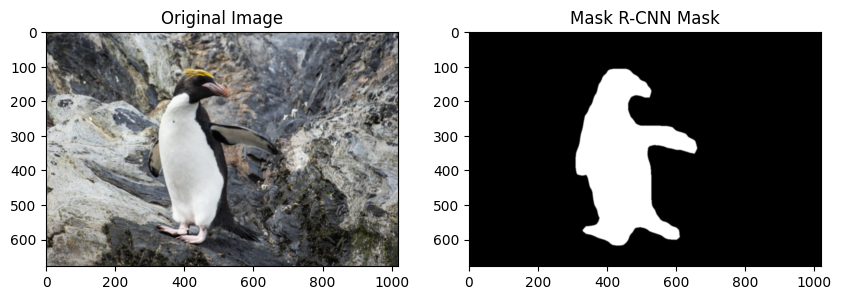

/content/drive/MyDrive/KernelGAN-Masks/masks/img1/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/obj_lr_mask.png


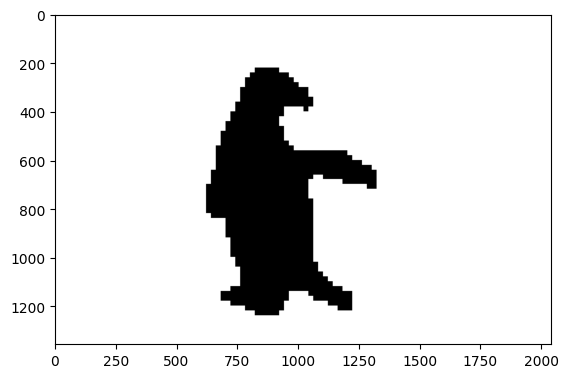

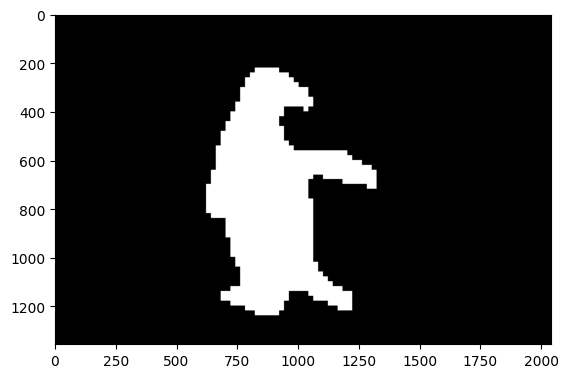

/content/drive/MyDrive/KernelGAN-Masks/imgs/img2


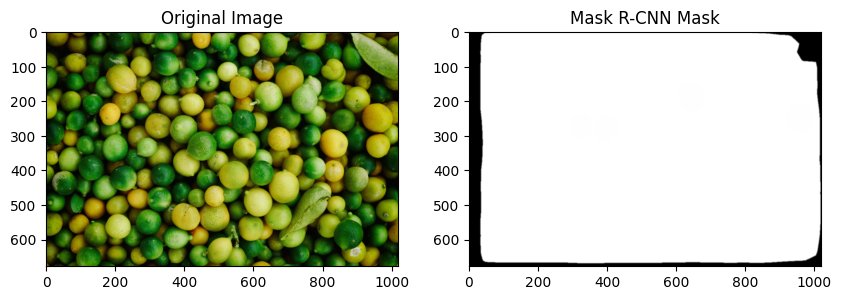

/content/drive/MyDrive/KernelGAN-Masks/masks/img2/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/obj_lr_mask.png


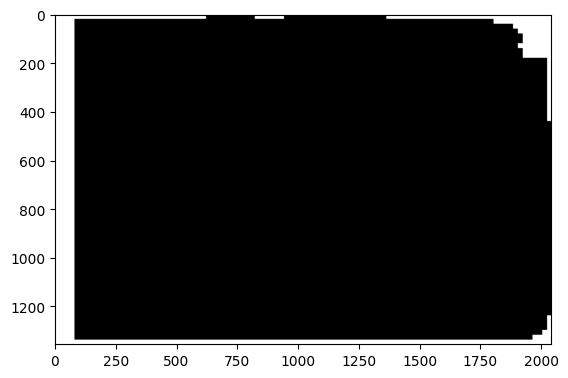

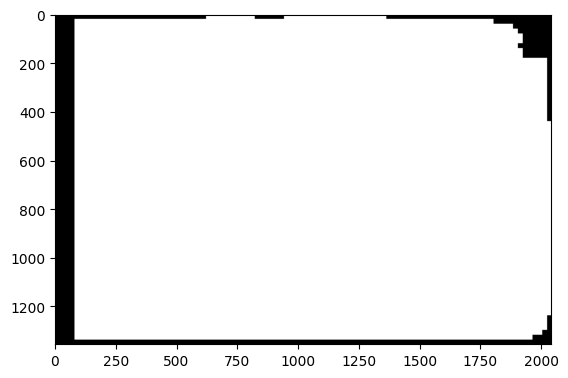

In [28]:
# Example usage
base_dir = "/content/drive/MyDrive/KernelGAN-Masks"
process_images(base_dir)